<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Colab" data-toc-modified-id="Colab-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Colab</a></span></li><li><span><a href="#Load-the-Libraries" data-toc-modified-id="Load-the-Libraries-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the Libraries</a></span></li><li><span><a href="#Useful-Scripts" data-toc-modified-id="Useful-Scripts-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Useful Scripts</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Choose-Prince-Musician-data-as-timeseries" data-toc-modified-id="Choose-Prince-Musician-data-as-timeseries-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Choose Prince Musician data as timeseries</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Data Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Add-lag-columns" data-toc-modified-id="Add-lag-columns-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Add lag columns</a></span></li><li><span><a href="#Add-bias-term" data-toc-modified-id="Add-bias-term-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Add bias term</a></span></li></ul></li><li><span><a href="#Add-timeseries-features" data-toc-modified-id="Add-timeseries-features-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Add timeseries features</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Train-Test-split" data-toc-modified-id="Train-Test-split-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Train Test split</a></span></li><li><span><a href="#Modelling:-Xgboost" data-toc-modified-id="Modelling:-Xgboost-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Modelling: Xgboost</a></span></li></ul></li><li><span><a href="#Adding-timeseries-features-using-tsfresh" data-toc-modified-id="Adding-timeseries-features-using-tsfresh-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Adding timeseries features using tsfresh</a></span></li><li><span><a href="#Using-Pipeline-for-tsfresh-relevant-feature-augmenter" data-toc-modified-id="Using-Pipeline-for-tsfresh-relevant-feature-augmenter-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Using Pipeline for tsfresh relevant feature augmenter</a></span></li><li><span><a href="#Cross-validation-for-timeseries" data-toc-modified-id="Cross-validation-for-timeseries-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Cross validation for timeseries</a></span></li><li><span><a href="#Time-Taken" data-toc-modified-id="Time-Taken-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Time Taken</a></span></li></ul></div>

# Data Description

Reference: https://www.kaggle.com/c/web-traffic-time-series-forecasting/data

```
Original data: train_1.csv
-----------------------------
rows = 145,063
columns = 551
first column = Page
date columns = 2015-07-01, 2015-07-02, ..., 2016-12-31 (550 columns)
file size: 284.6 MB
              
              
Data for modelling: Prince Musician
-------------------------------------------------------
timeseries  : 2016 page visits for Prince 

lag columns : lag1 to lag7
bias        : bias column

For ARIMA   : we have only one timeseries (one column)
For sklearn : For linear regressor, ensemble learners we can have many columns
```

# Colab

In [1]:
import time

time_start_notebook = time.time()

In [2]:
mkdir -p ~/.kaggle

In [3]:
# !echo '' > ~/.kaggle/kaggle.json


In [4]:
!chmod 600 ~/.kaggle/kaggle.json

# after we have ~/.kaggle/kaggle.json file in colab, we can install kaggle module.

In [5]:
!head -c 20 ~/.kaggle/kaggle.json

{"username":"bhishan

In [6]:
%%capture
# capture will not print in notebook

import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install watermark
    !pip install tsfresh

    ## create project like folders
    !mkdir -p ../data ../outputs ../images ../reports ../html ../models

    !pip install kaggle

In [7]:
# !kaggle competitions files -c web-traffic-time-series-forecasting

In [8]:
!kaggle competitions download -c web-traffic-time-series-forecasting -f train_1.csv.zip -p ../data/

train_1.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!ls ../data

most_visited_2016.csv train_1.csv.zip       train_1_01?raw=true   train_1_02?raw=true   train_1_03?raw=true


# Load the Libraries

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (12,8)})
plt.style.use('fivethirtyeight') # better than sns styles.
matplotlib.rcParams['figure.figsize'] = 12,8

import os
import time
import joblib

# random state
SEED=100
np.random.seed(SEED)

# Jupyter notebook settings for pandas
#pd.set_option('display.float_format', '{:,.2g}'.format) # numbers sep by comma
from pandas.api.types import CategoricalDtype
np.set_printoptions(precision=3)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 200)

import gc

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score

import xgboost
from xgboost import XGBRegressor
import scipy
from scipy import stats

import watermark

# versions
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-10-17 

CPython 3.7.7
IPython 7.18.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit

xgboost    1.2.0
numpy      1.18.4
seaborn    0.11.0
pandas     1.1.0
matplotlib 3.2.1
scipy      1.4.1
joblib     0.17.0
watermark  2.0.2
sklearn    0.23.1



In [11]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Useful Scripts

In [12]:
def show_method_attributes(method, ncols=7):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """
    x = [i for i in dir(method) if i[0].islower()]
    return pd.DataFrame(np.array_split(x,ncols)).T.fillna('')

In [13]:
def safe_median(s):
    return np.median([x for x in s if ~np.isnan(x)])

MAPE - Mean Absolute Percentage Error:
$$
M A P E=\frac{100}{n} \sum_{i=1}^{n} \frac{\left|y_{i}-\hat{y}_{i}\right|}{y_{i}}
$$


SMAPE - Symmetric Mean Absolute Percentage Error:

$$
S M A P E = \frac{100 \%}{n} \sum_{i=1}^{n} \frac{\left|y_{i} - \hat{y}\right|}{\left(\left|y_i\right| + \left|\hat{y}\right|\right) / 2}\\
\quad \quad = \frac{200 \%}{n} \sum_{i=1}^{n} \frac{\left|y_{i} - \hat{y}\right|}{ \left|y_i\right| + \left|\hat{y}\right|}
$$

In [14]:
def get_mape(y_true, y_pred):
    "Mean Absolute Percentage Error"
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_smape(y_true, y_pred):
    "Symmetric Mean Absolute Percentage Error"
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

In [15]:
def get_mape(y_true, y_pred):
    "Mean Absolute Percentage Error"
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_smape(y_true, y_pred):
    "Symmetric Mean Absolute Percentage Error"
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

def timeseries_evaluation(model_name, desc, ytest, ypreds, df_eval=None,
                          show=False,sort_col='SMAPE'):
    from statsmodels.tsa.stattools import acf

    if df_eval is None:
        df_eval = pd.DataFrame({'Model': [],
                                'Description':[],
                                'MAPE': [],
                                'SMAPE': [],
                                'RMSE': [],
                                'ME': [],
                                'MAE': [],
                                'MPE': [],
                                'CORR': [],
                                'MINMAX': [],
                                'ACF1': [],
                                })

    mape = get_mape(ytest,ypreds)   # MAPE
    smape = get_smape(ytest,ypreds) # SMAPE
    rmse = np.mean((ytest - ypreds)**2)**.5  # RMSE

    me = np.mean(ytest - ypreds)             # ME
    mae = np.mean(np.abs(ytest - ypreds))    # MAE
    mpe = np.mean((ytest - ypreds)/ytest)    # MPE

    corr = np.corrcoef(ytest, ypreds)[0, 1]  # corr

    mins = np.amin(np.hstack([ytest[:, None],
                              ypreds[:, None]]), axis=1)
    maxs = np.amax(np.hstack([ytest[:, None],
                              ypreds[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    acf1 = acf(ytest-ypreds, fft=False)[1]    # ACF1 (autocorrelation function)

    row = [model_name, desc, mape, smape,rmse, me,mae,mpe,corr,minmax,acf1]

    df_eval.loc[len(df_eval)] = row
    df_eval = df_eval.drop_duplicates(['Model','Description'])
    
    asc, cmap = True, 'Greens_r'
    
    if sort_col == 'RMSE':
        asc = False
        cmap = 'Greens'

    if sort_col == 'SMAPE':
        asc = True
        cmap = 'Greens_r'

    df_eval = df_eval.sort_values(sort_col,ascending=asc)
    df_eval = df_eval.reset_index(drop=True)

    if show:
        df_eval_style = (df_eval.style
                         .format({'MAPE': "{:,.0f}",
                                  'SMAPE': "{:,.4f}",
                                  'RMSE': "{:,.0f}",
                                  'ME': "{:,.0f}",
                                  'MAE': "{:,.0f}",
                                  'MPE': "{:,.0f}",
                                  'CORR': "{:,.4f}",
                                  'MINMAX': "{:,.4f}",
                                  'ACF1': "{:,.4f}"
                                 })
                         .background_gradient(subset=[sort_col],cmap=cmap)
                        )
        display(df_eval_style)
    return df_eval

df_eval = None

In [16]:
def plot_model_results(model,Xtrain, ytrain,Xtest,ytest,ypreds,
                       n_splits=5,
                       plot_intervals=False,
                       plot_anomalies=False):
    """Plot model performance for timeseries data.

    """
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import TimeSeriesSplit

    # plot
    plt.figure(figsize=(14, 8))
    plt.plot(ytest, "green", label="actual", linewidth=2.0)
    plt.plot(ypreds, "blue", label="ypreds", linewidth=2.0)

    tscv = TimeSeriesSplit(n_splits=n_splits)
    if plot_intervals:
        score_cv = cross_val_score(model,Xtrain,ytrain,
                                    cv=tscv,
                                    scoring="neg_mean_absolute_error")
        mae = score_cv.mean() * (-1)
        deviation = score_cv.std()

        scale = 1.96
        lower = ypreds - (mae + scale * deviation)
        upper = ypreds + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(ytest))
            anomalies[ytest<lower] = ytest[ytest<lower]
            anomalies[ytest>upper] = ytest[ytest>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    mape_error = get_mape(ytest, ypreds)
    smape_error = get_smape(ytest, ypreds)

    title = "MAPE : {:.2f} \nSMAPE: {:.2f}".format(mape_error, smape_error)
    plt.title(title)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

# Load the data

In [17]:
df = pd.read_csv('../data/train_1.csv.zip',compression='zip')

print(df.shape)
df.head()

(145063, 551)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,...,2016-11-12,2016-11-13,2016-11-14,2016-11-15,2016-11-16,2016-11-17,2016-11-18,2016-11-19,2016-11-20,2016-11-21,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,10.0,5.0,9.0,9.0,9.0,9.0,13.0,4.0,15.0,25.0,...,13.0,8.0,15.0,14.0,12.0,6.0,11.0,10.0,42.0,21.0,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,12.0,27.0,27.0,36.0,23.0,58.0,80.0,60.0,69.0,42.0,...,12.0,11.0,14.0,28.0,23.0,20.0,9.0,12.0,11.0,14.0,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,4.0,5.0,0.0,0.0,7.0,3.0,5.0,1.0,6.0,2.0,...,6.0,4.0,2.0,4.0,6.0,5.0,4.0,4.0,3.0,3.0,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,8.0,27.0,19.0,16.0,2.0,84.0,22.0,14.0,47.0,25.0,...,38.0,13.0,14.0,17.0,26.0,14.0,10.0,9.0,23.0,15.0,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,11.0,8.0,6.0,10.0,14.0,6.0,9.0,6.0,16.0,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


# Choose Prince Musician data as timeseries

In [18]:
cond = df['Page'] == "Prince_(musician)_en.wikipedia.org_all-access_all-agents"

df = df.loc[cond]
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,...,2016-11-12,2016-11-13,2016-11-14,2016-11-15,2016-11-16,2016-11-17,2016-11-18,2016-11-19,2016-11-20,2016-11-21,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
40563,Prince_(musician)_en.wikipedia.org_all-access_all-agents,9529.0,13627.0,9163.0,8222.0,7769.0,7640.0,8411.0,8746.0,6970.0,7072.0,7134.0,7313.0,6969.0,12577.0,16418.0,7487.0,7072.0,7314.0,7196.0,6785.0,6736.0,7661.0,9605.0,10634.0,8393.0,8548.0,8893.0,8960.0,7119.0,7939.0,7877.0,7309.0,7366.0,6505.0,7339.0,7798.0,9699.0,9754.0,14827.0,15815.0,14232.0,9910.0,8185.0,8089.0,8374.0,8933.0,10286.0,8747.0,7268.0,...,8474.0,10774.0,9190.0,8220.0,8744.0,10619.0,12532.0,10791.0,9323.0,22885.0,10711.0,9349.0,9880.0,10420.0,11213.0,16069.0,11077.0,11055.0,9930.0,10507.0,10964.0,10104.0,10321.0,10005.0,9909.0,10521.0,11002.0,11153.0,13712.0,15153.0,10304.0,10504.0,12701.0,14971.0,12159.0,10778.0,11292.0,10883.0,9788.0,9856.0,13222.0,11297.0,15963.0,17002.0,49774.0,34560.0,31090.0,22827.0,19956.0,31446.0


In [19]:
df = df.filter(regex="Page|2016")
df.iloc[:5, np.r_[0, 1,2,-2,-1]]

,Page,2016-01-01,2016-01-02,2016-12-30,2016-12-31
40563,Prince_(musician)_en.wikipedia.org_all-access_all-agents,20947.0,19466.0,19956.0,31446.0


In [20]:
df = df.melt(id_vars=['Page'],var_name='date',value_name='visits').drop('Page',axis=1)

print(df.shape)
df.head()

(366, 2)


,date,visits
0,2016-01-01,20947.0
1,2016-01-02,19466.0
2,2016-01-03,8587.0
3,2016-01-04,7386.0
4,2016-01-05,7719.0


In [21]:
df['visits'].isna().sum()

0

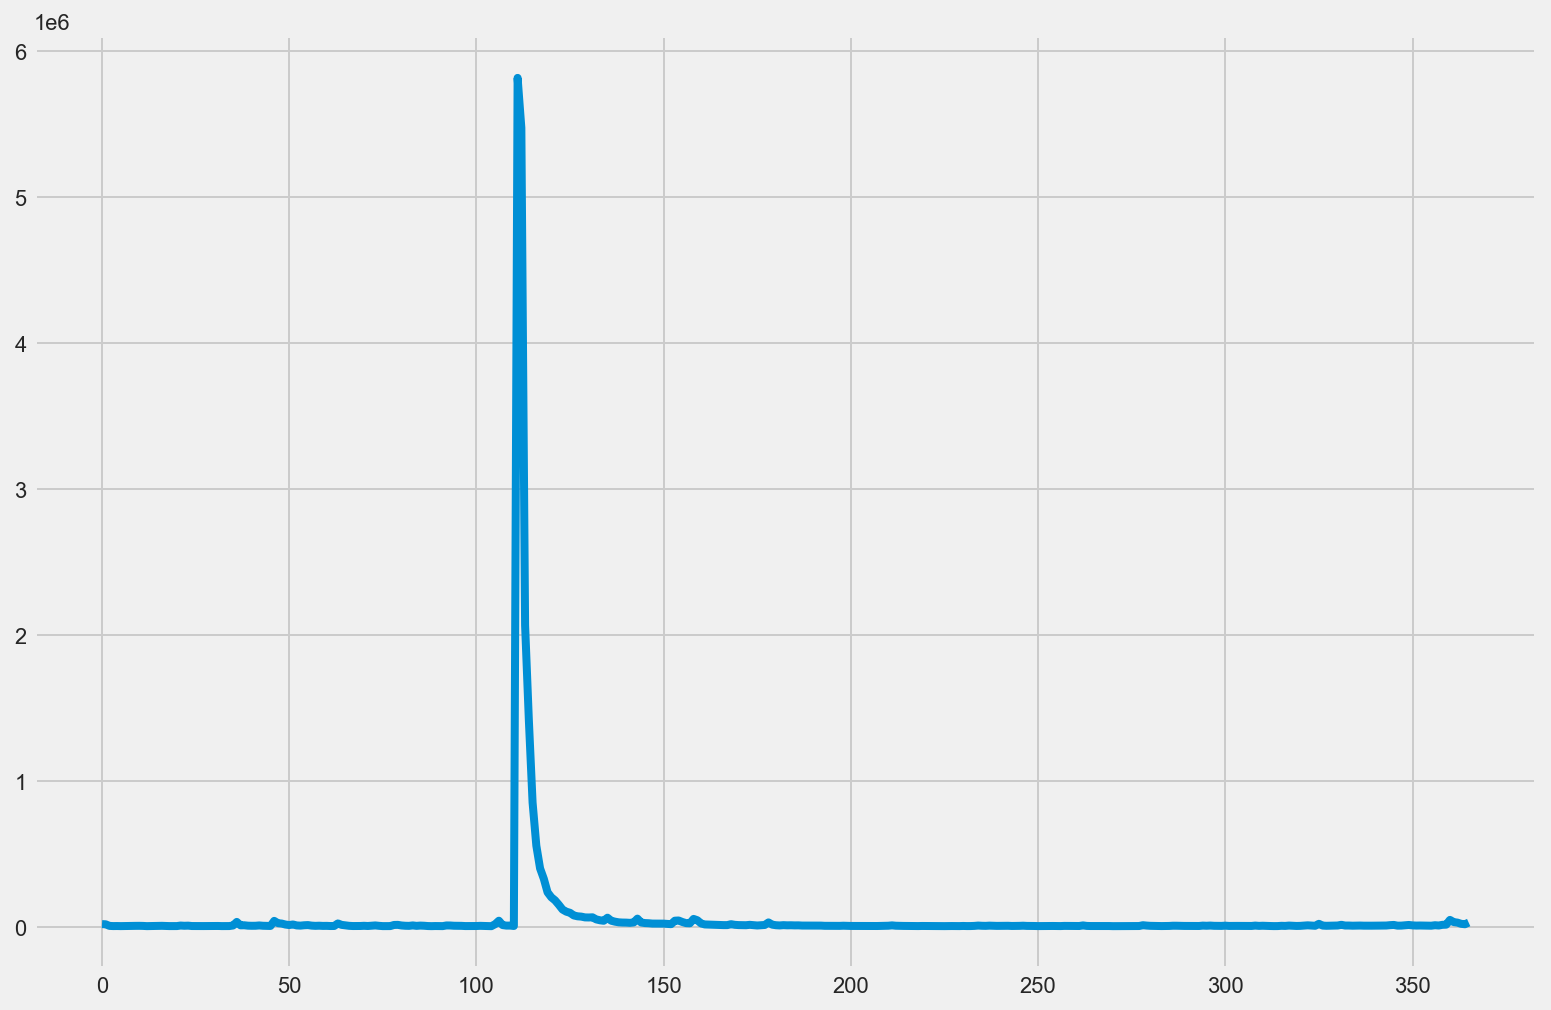

In [22]:
df['visits'].plot.line()

(0.0, 100000.0)

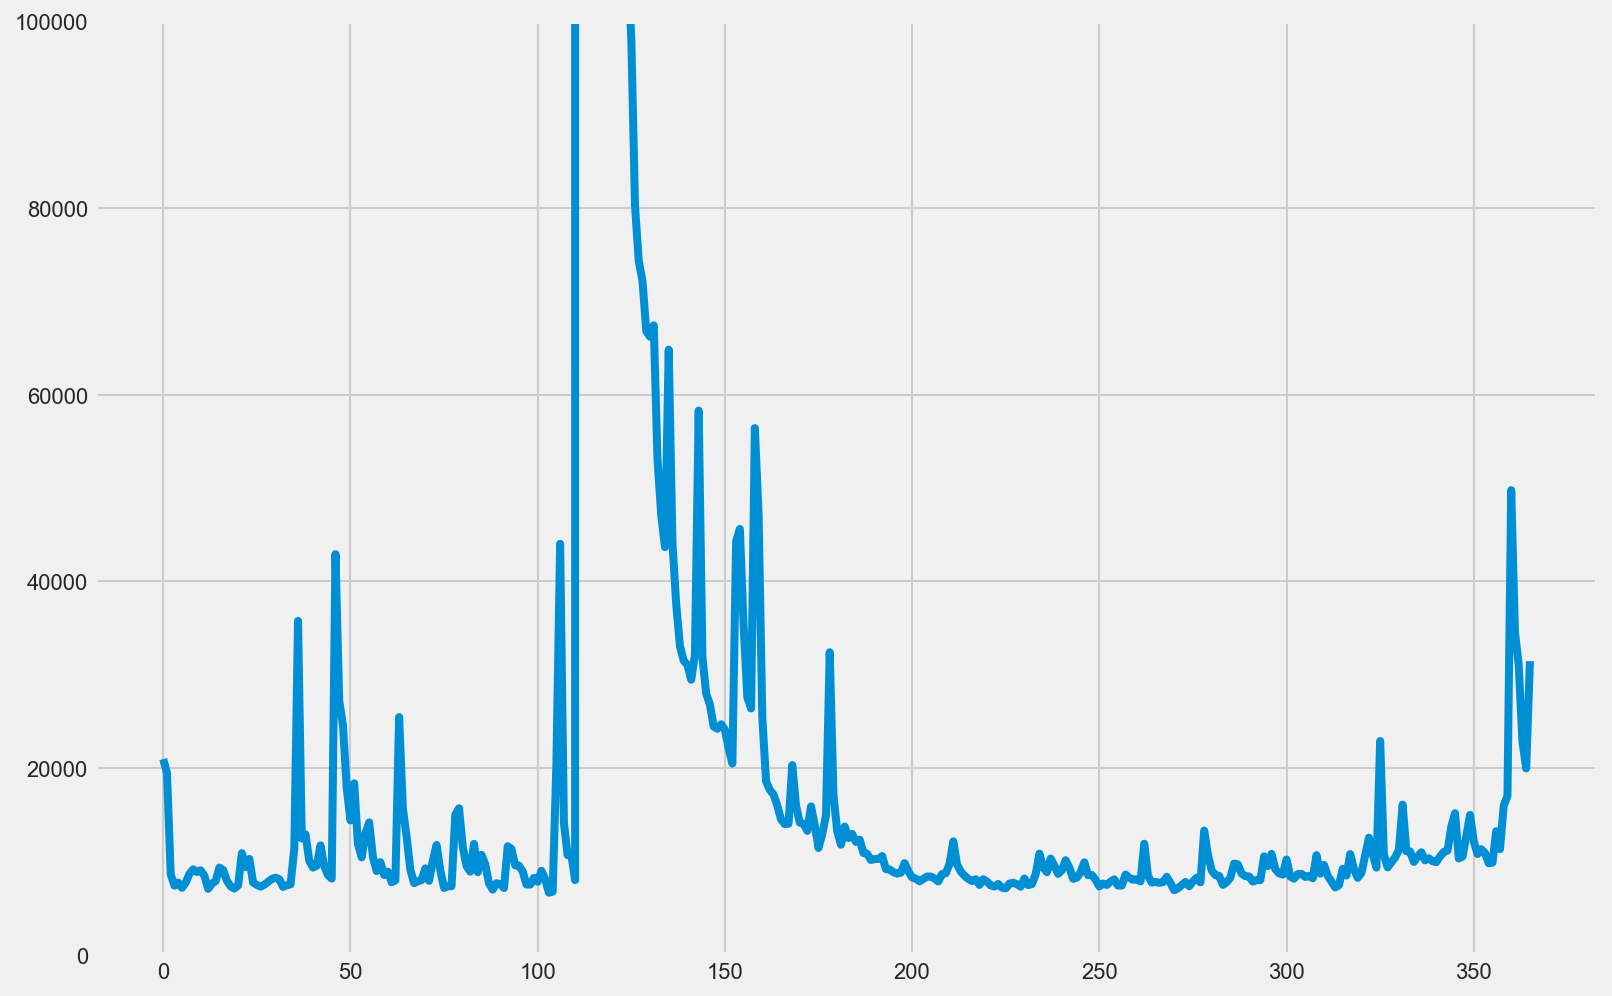

In [23]:
df['visits'].plot.line()
plt.ylim(0,1e5)

# Data Preprocessing

## Add lag columns

In [24]:
for lag in range(1,8):
    df['lag'+str(lag)] = df['visits'].shift(lag)

In [25]:
# adding lags will create nans
df.isna().sum().sum()

28

In [26]:
df = df.dropna(how='any')
df.head()

,date,visits,lag1,lag2,lag3,lag4,lag5,lag6,lag7
7,2016-01-08,8658.0,7713.0,7156.0,7719.0,7386.0,8587.0,19466.0,20947.0
8,2016-01-09,9137.0,8658.0,7713.0,7156.0,7719.0,7386.0,8587.0,19466.0
9,2016-01-10,8855.0,9137.0,8658.0,7713.0,7156.0,7719.0,7386.0,8587.0
10,2016-01-11,9034.0,8855.0,9137.0,8658.0,7713.0,7156.0,7719.0,7386.0
11,2016-01-12,8435.0,9034.0,8855.0,9137.0,8658.0,7713.0,7156.0,7719.0


## Add bias term

In [27]:
df['bias'] = 1

# Add timeseries features

In [28]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month # 1 to 12
df['day'] = df['date'].dt.day # 1 to 31

df['quarter'] = df['date'].dt.quarter # 1 to 4
df['dayofweek'] = df['date'].dt.dayofweek # 0 to 6

df['weekend'] = ((df['date'].dt.dayofweek) // 5 == 1).astype(np.int8)

# df = df.drop('date',axis=1)

print('nans = ',df.isna().sum().sum())
df.head()

nans =  0


,date,visits,lag1,lag2,lag3,lag4,lag5,lag6,lag7,bias,month,day,quarter,dayofweek,weekend
7,2016-01-08,8658.0,7713.0,7156.0,7719.0,7386.0,8587.0,19466.0,20947.0,1,1,8,1,4,0
8,2016-01-09,9137.0,8658.0,7713.0,7156.0,7719.0,7386.0,8587.0,19466.0,1,1,9,1,5,1
9,2016-01-10,8855.0,9137.0,8658.0,7713.0,7156.0,7719.0,7386.0,8587.0,1,1,10,1,6,1
10,2016-01-11,9034.0,8855.0,9137.0,8658.0,7713.0,7156.0,7719.0,7386.0,1,1,11,1,0,0
11,2016-01-12,8435.0,9034.0,8855.0,9137.0,8658.0,7713.0,7156.0,7719.0,1,1,12,1,1,0


# Modelling

## Train Test split

In [29]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop('date',1),
                                                df['visits'],
                                                test_size=0.2,shuffle=False)

print(Xtrain.shape, Xtest.shape)

(287, 14) (72, 14)


In [30]:
target = 'visits'
features = df.columns.drop(['date', target])
df_Xtrain = pd.DataFrame(Xtrain, columns=features)
df_Xtest = pd.DataFrame(Xtest, columns=features)
df_Xtrain.head(2)

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,bias,month,day,quarter,dayofweek,weekend
7,7713.0,7156.0,7719.0,7386.0,8587.0,19466.0,20947.0,1,1,8,1,4,0
8,8658.0,7713.0,7156.0,7719.0,7386.0,8587.0,19466.0,1,1,9,1,5,1


## Modelling: Xgboost

In [31]:
from xgboost import XGBRegressor

In [32]:
# XGBRegressor?

/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,


,Model,Description,MAPE,SMAPE,RMSE,ME,MAE,MPE,CORR,MINMAX,ACF1
0,xgb,default,1,1.4308,453,9,224,0,0.9978,0.0141,-0.3971


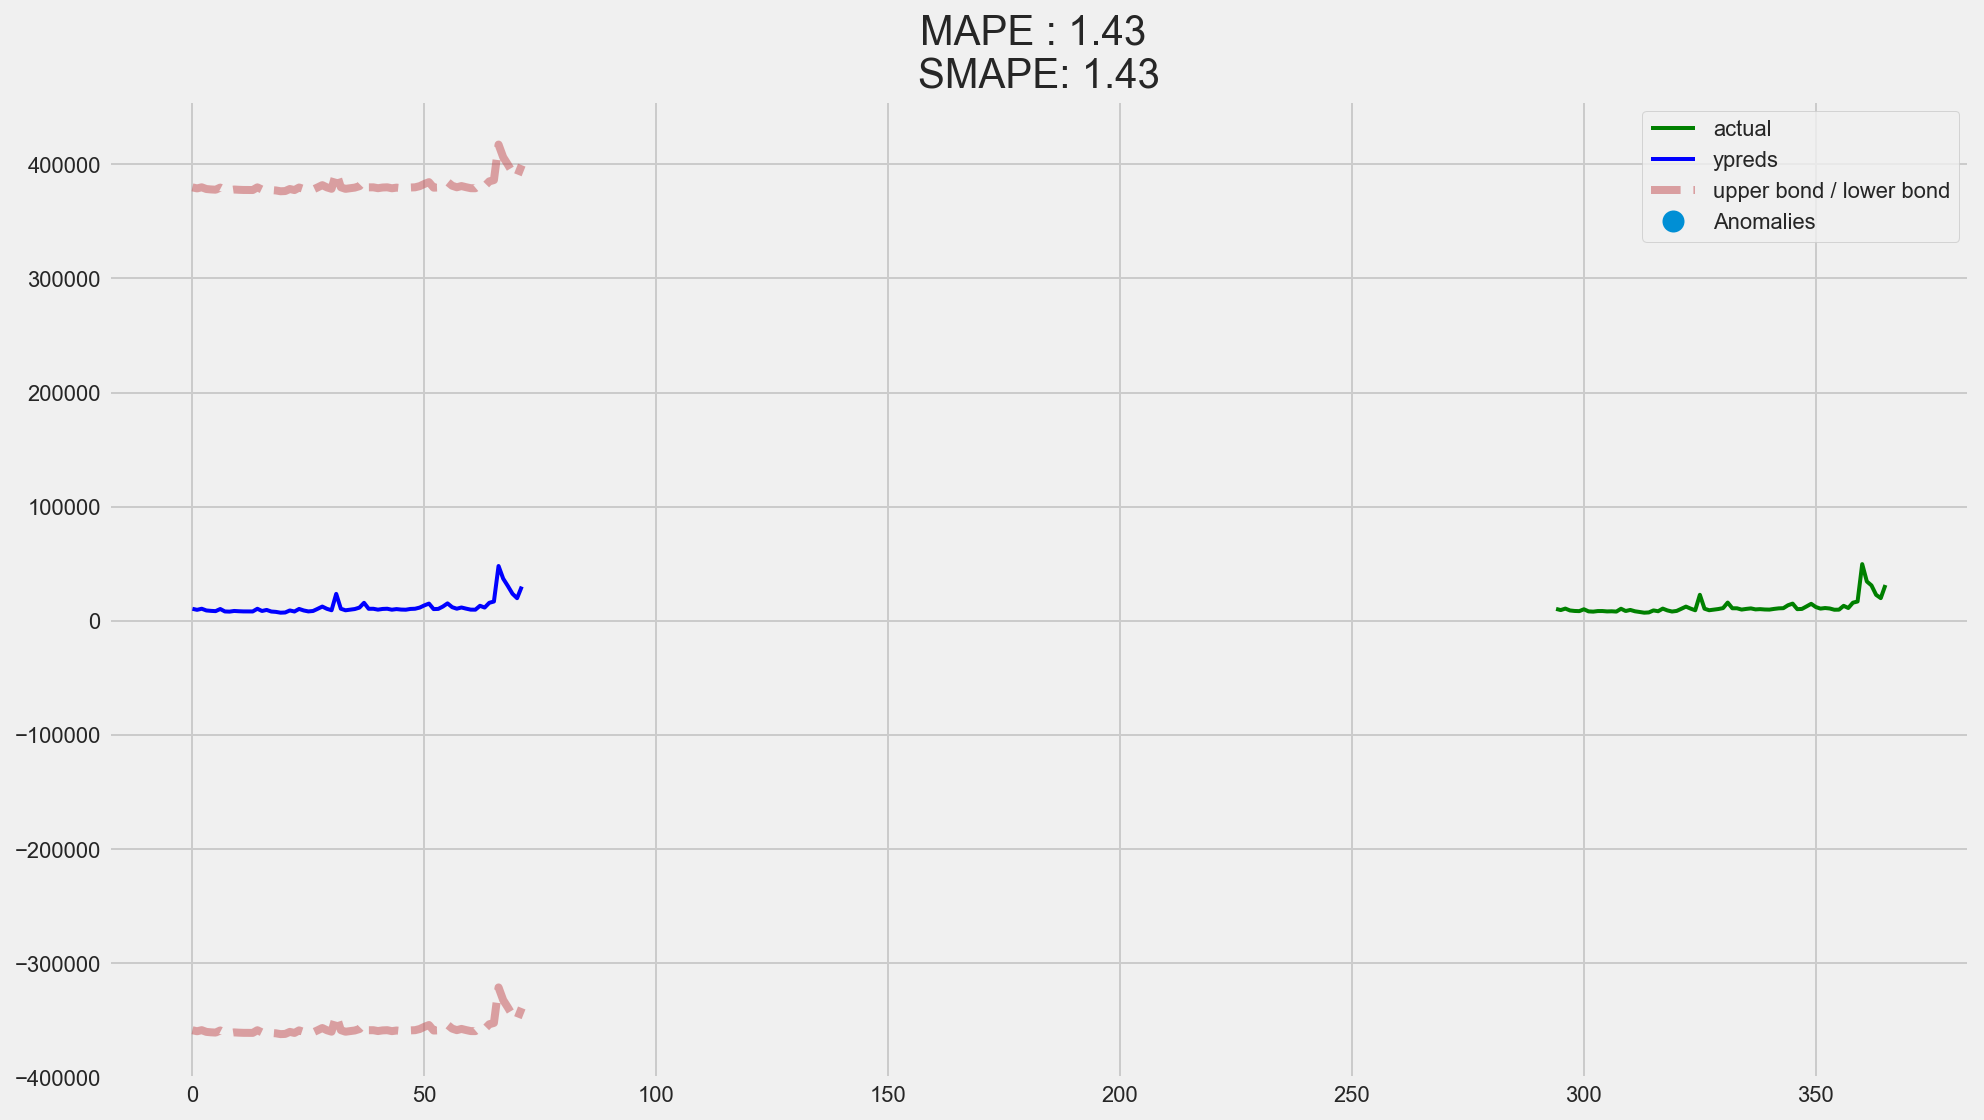

In [33]:
model = XGBRegressor(random_state=SEED,n_jobs=-1,objective='reg:squarederror')
model.fit(Xtrain, ytrain)
ypreds = model.predict(Xtest)

plot_model_results(model, 
                 Xtrain=Xtrain,ytrain=ytrain,
                 Xtest=Xtest,ytest=ytest,ypreds=ypreds,
                 plot_intervals=True, plot_anomalies=True)

model_name = 'xgb'
desc = 'default'
df_eval = timeseries_evaluation(model_name, desc, ytest, ypreds,
                    df_eval=df_eval,show=True)

# Adding timeseries features using tsfresh
Ref: https://github.com/blue-yonder/tsfresh/blob/main/notebooks/examples/01%20Feature%20Extraction%20and%20Selection.ipynb

In [34]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

In [35]:
%%time
df = pd.read_csv('../data/train_1.csv.zip',compression='zip')

cond = df['Page'] == "Prince_(musician)_en.wikipedia.org_all-access_all-agents"
df = df.loc[cond]

df = df.filter(regex="Page|2016")

df = df.melt(id_vars=['Page'],var_name='date',value_name='visits').drop('Page',axis=1)
df = df.dropna(how='any')

print(df.shape)

df['id'] = df.index

df.iloc[:2,:5]

(366, 2)
CPU times: user 8.03 s, sys: 760 ms, total: 8.79 s
Wall time: 9.41 s


,date,visits,id
0,2016-01-01,20947.0,0
1,2016-01-02,19466.0,1


In [36]:
%%time

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

# we impute = remove all NaN features automatically
extraction_settings = ComprehensiveFCParameters()
df_extr = extract_features(df, column_id='id', column_sort='date',
                     default_fc_parameters=extraction_settings,
                     impute_function=impute)

Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Extraction:  10%|█         | 1/10 [00:01<00:11,  1.22s/it]

Feature Extraction:  30%|███       | 3/10 [00:02<00:07,  1.03s/it]

Feature Extraction:  50%|█████     | 5/10 [00:03<00:04,  1.12it/s]

Feature Extraction:  70%|███████   | 7/10 [00:04<00:02,  1.30it/s]

Feature Extraction:  90%|█████████ | 9/10 [00:05<00:00,  1.51it/s]

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

CPU times: user 724 ms, sys: 115 ms, total: 839 ms
Wall time: 5.92 s


In [37]:
df_extr.shape

(366, 779)

In [38]:
%%time
df_extr_sel = select_features(df_extr, df['visits'])
df_extr_sel.shape

CPU times: user 64 ms, sys: 22.8 ms, total: 86.7 ms
Wall time: 122 ms


(366, 21)

In [39]:
df_Xtrain, df_Xtest, ser_ytrain, ser_ytest = train_test_split(
    df_extr_sel, df['visits'],test_size=0.2,shuffle=False)

Xtrain = df_Xtrain.to_numpy()
Xtest = df_Xtest.to_numpy()
ytrain = ser_ytrain.to_numpy().ravel()
ytest = ser_ytest.to_numpy().ravel()

print(df_Xtrain.shape, df_Xtest.shape)
# df_Xtrain.iloc[:10,:5]

(292, 21) (74, 21)


In [40]:
# make sure the data is not shuffled
# df_extr_sel.iloc[:10,:5]

In [41]:
# df_extr_sel.iloc[-5:,:5]

In [42]:
# df_Xtest.iloc[-5:,:5]

/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,


,Model,Description,MAPE,SMAPE,RMSE,ME,MAE,MPE,CORR,MINMAX,ACF1
0,xgb,tsfresh,1,0.6356,337,43,115,0,0.9991,0.0063,-0.2886
1,xgb,default,1,1.4308,453,9,224,0,0.9978,0.0141,-0.3971


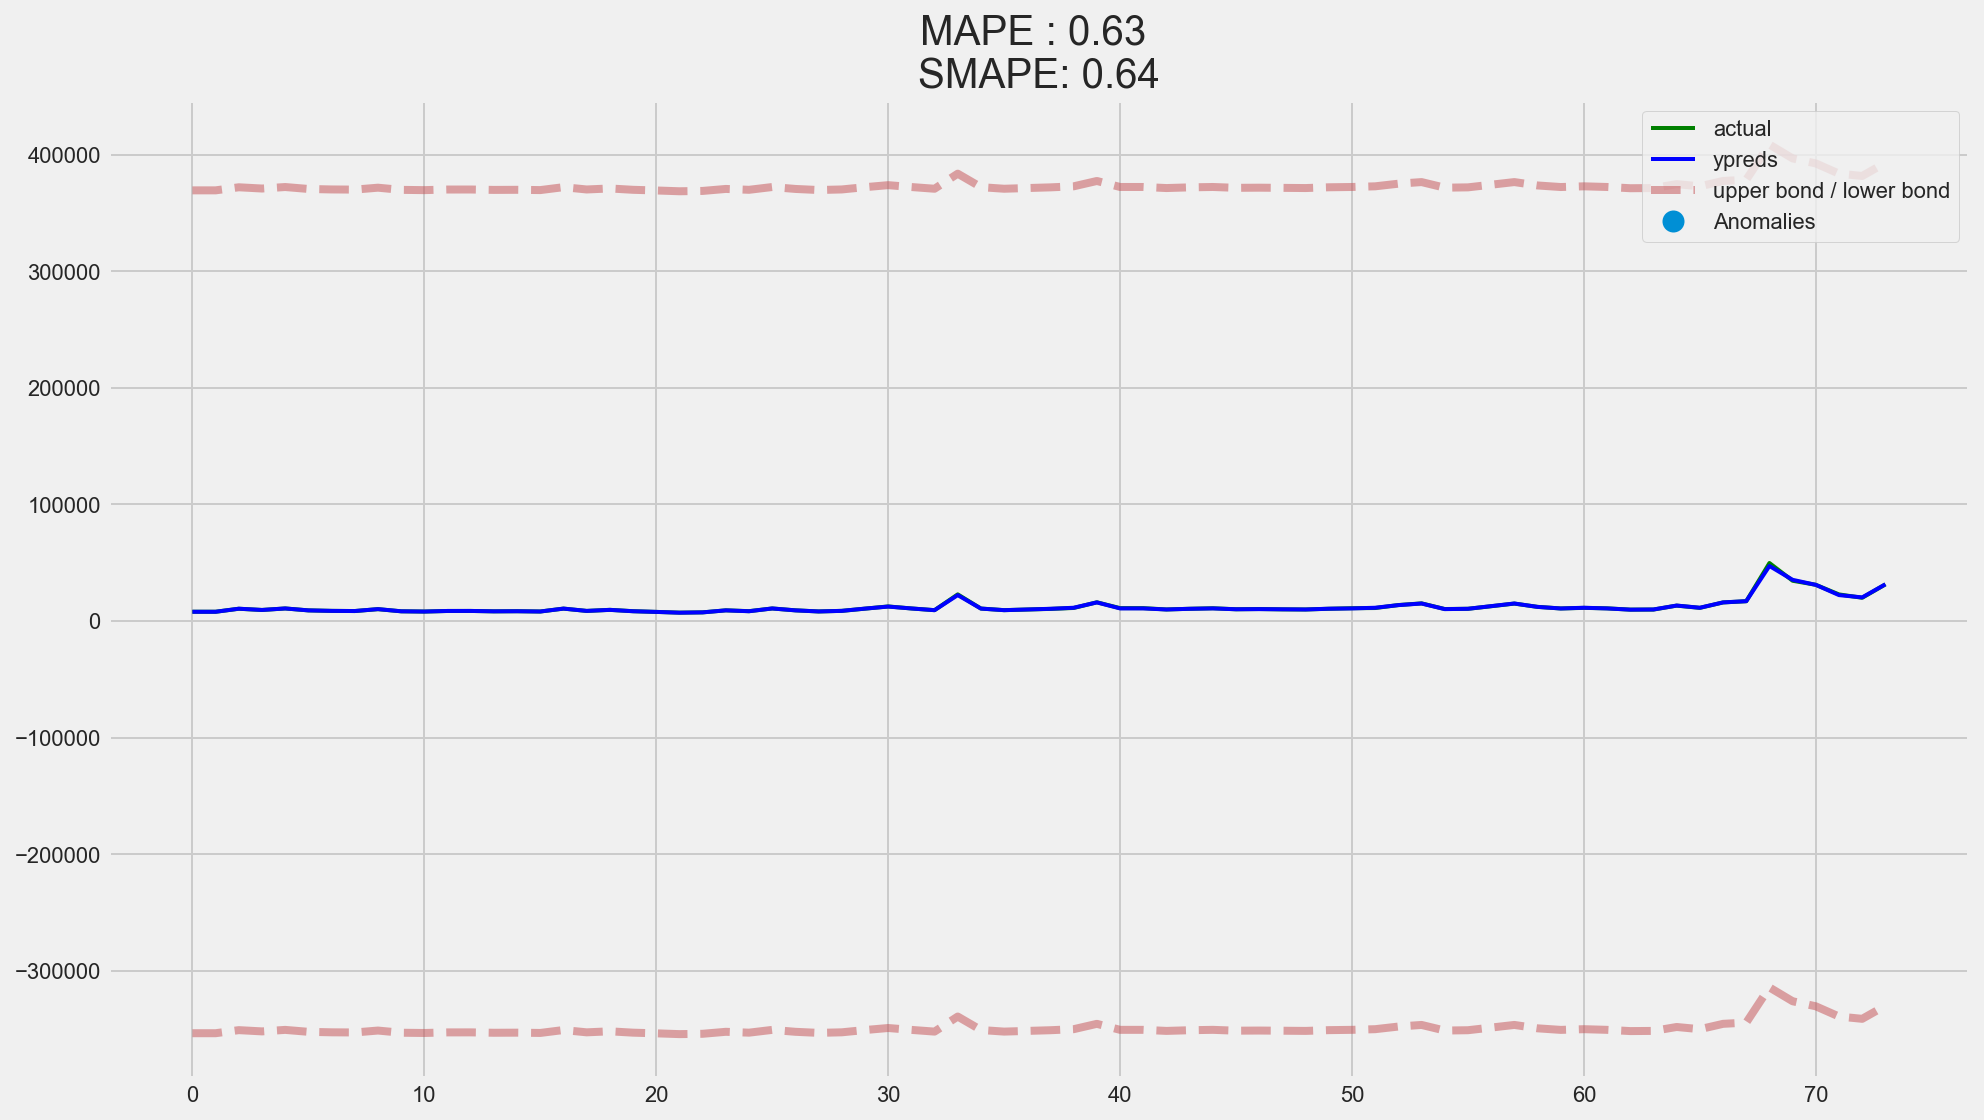

In [43]:
model = XGBRegressor(random_state=SEED,n_jobs=-1,objective='reg:squarederror')
model.fit(Xtrain, ytrain)
ypreds = model.predict(Xtest)

plot_model_results(model, 
                 Xtrain=Xtrain,ytrain=ytrain,
                 Xtest=Xtest,ytest=ytest,ypreds=ypreds,
                 plot_intervals=True, plot_anomalies=True)

model_name = 'xgb'
desc = 'tsfresh'
df_eval = timeseries_evaluation(model_name, desc, ytest, ypreds,
                    df_eval=df_eval,show=True)

# Using Pipeline for tsfresh relevant feature augmenter
Ref: https://github.com/blue-yonder/tsfresh/blob/main/notebooks/examples/02%20sklearn%20Pipeline.ipynb

In [44]:
from sklearn.pipeline import Pipeline
from tsfresh.transformers import RelevantFeatureAugmenter

In [45]:
df_Xtrain.iloc[:2,:5]

,visits__sum_values,"visits__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","visits__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","visits__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","visits__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)"
0,20947.0,4062.456606,5745.181229,8124.913212,12846.615771
1,19466.0,3775.231789,5338.983998,7550.463579,11938.331150


In [46]:
df_extr_sel.iloc[:2,:5]

,visits__sum_values,"visits__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","visits__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","visits__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","visits__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)"
0,20947.0,4062.456606,5745.181229,8124.913212,12846.615771
1,19466.0,3775.231789,5338.983998,7550.463579,11938.331150


In [47]:
# we need dataframe with columns id and date to use pipeline

In [48]:
df.iloc[:2,:5]

,date,visits,id
0,2016-01-01,20947.0,0
1,2016-01-02,19466.0,1


In [49]:
df_train, df_test, ser_ytrain, ser_ytest = train_test_split(df,df['visits'],
                                                shuffle=False,test_size=0.2)
print(df.shape, df_train.shape)
df_train.iloc[:2,:5]

(366, 3) (292, 3)


,date,visits,id
0,2016-01-01,20947.0,0
1,2016-01-02,19466.0,1


In [50]:
# create empty dataframe

df_empty = pd.DataFrame(index=df.index)

df_Xtrain_empty, df_Xtest_empty = train_test_split(df_empty,shuffle=False,test_size=0.2)

df_empty.head()

""
0
1
2
3
4


In [51]:
%%capture

pipe = Pipeline([
        ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='date')),
        ('regressor', XGBRegressor(random_state=SEED,n_jobs=-1,objective='reg:squarederror'))
      ])

pipe.set_params(augmenter__timeseries_container=df_train);
pipe.fit(df_Xtrain_empty, ser_ytrain);

path_pipe = '../models/pipeline.joblib'
joblib.dump(pipe, path_pipe)

In [52]:
# load the fitted pipeline and again assingn new augmenter
pipe = joblib.load(path_pipe)

pipe.set_params(augmenter__timeseries_container=df_test);
ypreds = pipe.predict(df_Xtest_empty)

Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 217.44it/s]

In [53]:
ypreds[:5]

array([ 7939.966,  7939.966, 10576.055,  9504.858, 10793.434],
      dtype=float32)

In [54]:
get_smape(ytest,ypreds)

0.6356307432712617

# Cross validation for timeseries
```
fold 1 : training [1], test [2]
fold 2 : training [1 2], test [3]
fold 3 : training [1 2 3], test [4]
fold 4 : training [1 2 3 4], test [5]
fold 5 : training [1 2 3 4 5], test [6]
```

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

In [56]:
model = XGBRegressor(random_state=SEED,n_jobs=-1,objective='reg:squarederror')
tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(model,Xtrain,ytrain,cv=tscv,n_jobs=-1,
                         scoring=make_scorer(get_smape))

scores

array([ 1.177, 56.18 ,  1.225,  0.377,  0.279])

In [57]:
df_train.head(2)

,date,visits,id
0,2016-01-01,20947.0,0
1,2016-01-02,19466.0,1


In [58]:
print(df_Xtrain.shape)
df_Xtrain.head(2)

(292, 21)


,visits__sum_values,"visits__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","visits__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","visits__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","visits__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",visits__quantile__q_0.9,visits__quantile__q_0.8,visits__quantile__q_0.7,visits__quantile__q_0.6,"visits__fft_coefficient__attr_""real""__coeff_0",visits__quantile__q_0.4,visits__quantile__q_0.2,visits__quantile__q_0.1,visits__minimum,visits__maximum,visits__mean,visits__median,visits__abs_energy,visits__quantile__q_0.3,"visits__fft_coefficient__attr_""abs""__coeff_0",visits__benford_correlation
0,20947.0,4062.456606,5745.181229,8124.913212,12846.615771,20947.0,20947.0,20947.0,20947.0,20947.0,20947.0,20947.0,20947.0,20947.0,20947.0,20947.0,20947.0,438776809.0,20947.0,20947.0,0.295657
1,19466.0,3775.231789,5338.983998,7550.463579,11938.331150,19466.0,19466.0,19466.0,19466.0,19466.0,19466.0,19466.0,19466.0,19466.0,19466.0,19466.0,19466.0,378925156.0,19466.0,19466.0,0.864123


In [59]:
tscv = TimeSeriesSplit(n_splits=5)
smapes = []
for i, (idx_tr, idx_vd) in enumerate(tscv.split(df_Xtrain)):

    Xtr = df_Xtrain.iloc[idx_tr]
    Xvd = df_Xtrain.iloc[idx_vd]
    ytr = ser_ytrain.iloc[idx_tr].to_numpy().ravel()
    yvd = ser_ytrain.iloc[idx_vd].to_numpy().ravel()

    model = XGBRegressor(random_state=SEED,n_jobs=-1,objective='reg:squarederror')
    model.fit(Xtr,ytr)
    vd_preds = model.predict(Xvd)

    smape = get_smape(yvd, vd_preds)
    smapes.append(smape)

    # info
    print()
    print('Fold                  : Fold {}'.format(i+1))
    print('training   data shape : {}'.format(idx_tr.shape))
    print('validation data shape : {}'.format(idx_vd.shape))
    print('SMAPE                 : {:.3f}'.format(smape))

smapes


Fold                  : Fold 1
training   data shape : (52,)
validation data shape : (48,)
SMAPE                 : 1.177

Fold                  : Fold 2
training   data shape : (100,)
validation data shape : (48,)
SMAPE                 : 56.180

Fold                  : Fold 3
training   data shape : (148,)
validation data shape : (48,)
SMAPE                 : 1.225

Fold                  : Fold 4
training   data shape : (196,)
validation data shape : (48,)
SMAPE                 : 0.377



Fold                  : Fold 5
training   data shape : (244,)
validation data shape : (48,)
SMAPE                 : 0.279


[1.1773017114187323,
 56.18010584713199,
 1.225068082605304,
 0.37743419598934896,
 0.2785122686770567]

# Time Taken

In [60]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 0 min 55 secs
